In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D

from torch.utils.data import DataLoader, dataset, TensorDataset

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../insight')
from archive import archive 

import torch.nn.functional as F

In [3]:
import torch.nn.functional as F

class RandomToNormalNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers):
        super(RandomToNormalNN, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)
        ])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()  # You can experiment with other activation functions
    
    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x



In [40]:
input_dim = 1
hidden_dim = 128
output_dim = 1
num_hidden_layers = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = RandomToNormalNN(input_dim, hidden_dim, output_dim, num_hidden_layers).to(device)

nepochs=100
bs = 1000
z_dim=1
epsilon = 0.5

# Create an instance of the neural network
base_distribution = D.Normal(torch.zeros(z_dim), torch.ones(z_dim))

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


In [41]:
random_input = torch.rand(10000, input_dim)
dset = TensorDataset(random_input)
loader = DataLoader(dset, batch_size=100, shuffle=True)

In [42]:
base_distribution = D.Normal(torch.zeros(z_dim), torch.ones(z_dim))

for e in range(nepochs):
    for x in loader:
    
        optimizer.zero_grad()
    
        output = model(x[0].unsqueeze(1).to(device))
    
        loss = base_distribution.log_prob(output.cpu()).to(device)
        loss = -loss.mean()
        loss.backward()
        optimizer.step() 
        
    print('epoch ',e, loss.item())

    

epoch  0 0.918938398361206
epoch  1 0.918938398361206
epoch  2 0.918938398361206
epoch  3 0.918938398361206
epoch  4 0.918938398361206
epoch  5 0.918938398361206
epoch  6 0.918938398361206
epoch  7 0.918938398361206
epoch  8 0.918938398361206
epoch  9 0.918938398361206
epoch  10 0.918938398361206
epoch  11 0.918938398361206
epoch  12 0.918938398361206
epoch  13 0.918938398361206
epoch  14 0.918938398361206


KeyboardInterrupt: 

In [79]:
loss

tensor(0.9507, grad_fn=<NegBackward0>)

In [80]:

# Generate random input
random_input = torch.rand(1000, input_dim)  # You can adjust the batch size
output = model(random_input)

print(output)


tensor([[0.9970],
        [0.9916],
        [1.0080],
        [1.0096],
        [0.9892],
        [1.0066],
        [0.9949],
        [1.0210],
        [1.0041],
        [0.9981],
        [1.0033],
        [0.9885],
        [1.0145],
        [1.0075],
        [1.0223],
        [0.9913],
        [1.0128],
        [0.9889],
        [1.0095],
        [0.9927],
        [0.9925],
        [1.0221],
        [1.0108],
        [1.0112],
        [1.0038],
        [0.9891],
        [0.9887],
        [0.9949],
        [0.9885],
        [1.0030],
        [1.0090],
        [1.0156],
        [0.9911],
        [1.0166],
        [0.9888],
        [1.0066],
        [1.0073],
        [1.0067],
        [0.9943],
        [1.0096],
        [0.9915],
        [1.0128],
        [0.9921],
        [1.0151],
        [1.0113],
        [1.0126],
        [1.0006],
        [1.0071],
        [1.0146],
        [0.9968],
        [1.0029],
        [1.0010],
        [1.0244],
        [0.9951],
        [0.9949],
        [1

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([-4.9999651e-01, -3.9999652e-01, -2.9999653e-01, -1.9999652e-01,
        -9.9996522e-02,  3.4766272e-06,  1.0000347e-01,  2.0000347e-01,
         3.0000347e-01,  4.0000346e-01,  5.0000346e-01], dtype=float32),
 <BarContainer object of 10 artists>)

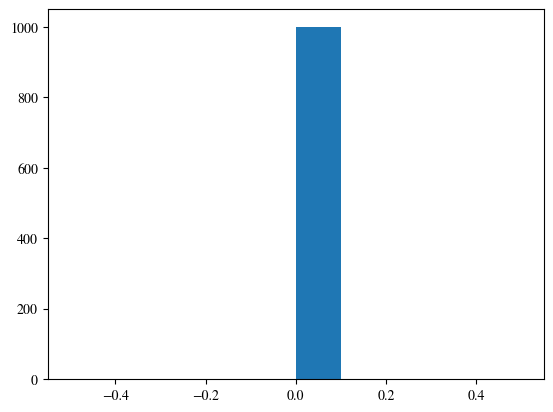

In [56]:
plt.hist(output.detach().cpu().numpy()[:,0])

In [30]:
from torch import nn


class RBF(nn.Module):

    def __init__(self, n_kernels=5, mul_factor=2.0, bandwidth=None):
        super().__init__()
        self.bandwidth_multipliers = mul_factor ** (torch.arange(n_kernels) - n_kernels // 2)
        self.bandwidth = bandwidth

    def get_bandwidth(self, L2_distances):
        if self.bandwidth is None:
            n_samples = L2_distances.shape[0]
            return L2_distances.data.sum() / (n_samples ** 2 - n_samples)

        return self.bandwidth

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2
        return torch.exp(-L2_distances[None, ...] / (self.get_bandwidth(L2_distances) * self.bandwidth_multipliers)[:, None, None]).sum(dim=0)


class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y):
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        XX = K[:X_size, :X_size].mean()
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].mean()
        return XX - 2 * XY + YY

In [119]:
input_dim = 1
hidden_dim = 128
output_dim = 1
num_hidden_layers = 3

model = RandomToNormalNN(input_dim, hidden_dim, output_dim, num_hidden_layers)

nepochs=1000
bs = 1000
z_dim=1
epsilon = 0.5

# Create an instance of the neural network
base_distribution = D.Normal(torch.zeros(z_dim), torch.ones(z_dim))
mmd = MMDLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


In [120]:
for e in range(nepochs):
    
    optimizer.zero_grad()
    
    random_input = torch.rand(bs, input_dim)
    randomN_input = torch.randn(bs, input_dim)

    output = model(random_input)
    
    loss =  mmd(output,randomN_input) #-base_distribution.log_prob(output).mean()
    #loss = loss.mean()
    loss.backward()
    optimizer.step() 
    
    

KeyboardInterrupt: 

(array([ 99., 102., 110.,  89., 105., 100., 100., 101., 105.,  89.]),
 array([4.2331219e-04, 1.0035120e-01, 2.0027909e-01, 3.0020696e-01,
        4.0013486e-01, 5.0006270e-01, 5.9999061e-01, 6.9991851e-01,
        7.9984641e-01, 8.9977425e-01, 9.9970216e-01], dtype=float32),
 <BarContainer object of 10 artists>)

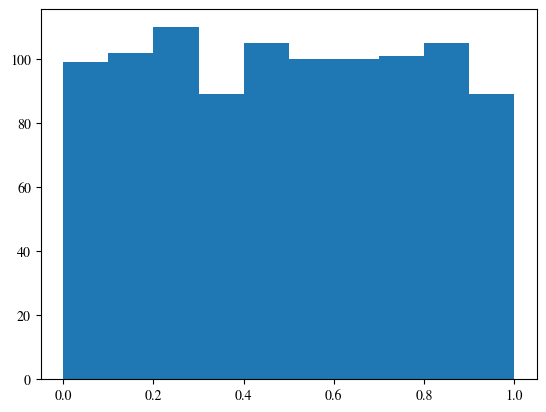

In [116]:
plt.hist(random_input.detach().cpu().numpy()[:,0])

(array([20., 17., 13.,  8., 10., 12.,  9., 11., 15., 10., 15., 15., 18.,
        16., 24., 35., 30., 29., 32., 25., 36., 27., 38., 27., 32., 32.,
        24., 31., 33., 28., 28., 26., 27., 27., 24., 27., 17., 18., 10.,
         9., 12.,  7., 11.,  8., 15.,  5., 14., 18., 13., 12.]),
 array([-1.945116  , -1.8679345 , -1.7907529 , -1.7135713 , -1.6363897 ,
        -1.5592082 , -1.4820266 , -1.404845  , -1.3276634 , -1.2504818 ,
        -1.1733003 , -1.0961187 , -1.0189371 , -0.9417555 , -0.8645739 ,
        -0.7873923 , -0.71021074, -0.63302916, -0.5558476 , -0.47866598,
        -0.4014844 , -0.32430282, -0.24712123, -0.16993965, -0.09275807,
        -0.01557648,  0.0616051 ,  0.13878669,  0.21596827,  0.29314986,
         0.37033144,  0.447513  ,  0.5246946 ,  0.6018762 ,  0.6790578 ,
         0.75623935,  0.83342093,  0.9106025 ,  0.9877841 ,  1.0649657 ,
         1.1421473 ,  1.2193289 ,  1.2965105 ,  1.373692  ,  1.4508736 ,
         1.5280552 ,  1.6052368 ,  1.6824183 ,  1.7595999 ,

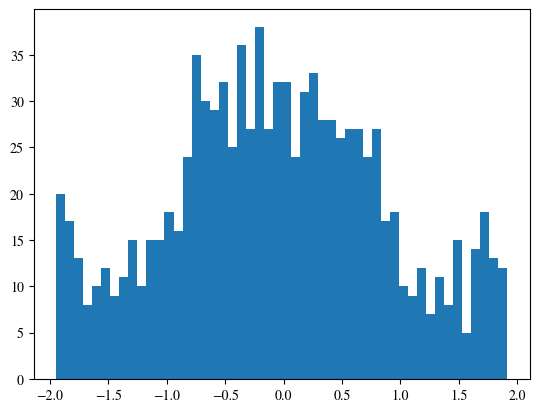

In [121]:
plt.hist(output.detach().cpu().numpy()[:,0], bins = 50)

## same with simple normalizing flow

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import matplotlib.pyplot as plt

class NormalizingFlow(nn.Module):
    def __init__(self, input_dim, num_flows):
        super(NormalizingFlow, self).__init__()
        self.flows = nn.ModuleList([PlanarFlow(input_dim) for _ in range(num_flows)])

    def forward(self, z):
        det_jacobian = torch.ones(z.size(0), 1)
        for flow in self.flows:
            z, jacobian = flow(z)
            det_jacobian *= jacobian
        return z, det_jacobian


In [9]:
class PlanarFlow(nn.Module):
    def __init__(self, input_dim):
        super(PlanarFlow, self).__init__()
        self.input_dim = input_dim
        self.weight = nn.Parameter(torch.randn(1, input_dim))
        self.bias = nn.Parameter(torch.randn(1))
        self.scale = nn.Parameter(torch.randn(1))

    def forward(self, z):
        # Transformation function
        z_flow = z + self.scale * torch.tanh(torch.mm(z, self.weight.t()) + self.bias)
        # Absolute determinant of the Jacobian
        psi = (1 - torch.tanh(torch.mm(z, self.weight.t()) + self.bias) ** 2) * self.weight
        det_jacobian = torch.abs(1 + torch.mm(psi, self.weight.t()))
        return z_flow, det_jacobian

In [58]:
# Define dimensions
input_dim = 1

z_dim = input_dim
nepochs=100
bs=1000
num_flows=20
# Instantiate the PlanarFlow transformation
flow = NormalizingFlow(input_dim, num_flows)
base_distribution = D.Normal(torch.zeros(z_dim), torch.ones(z_dim))


In [77]:
optimizer = optim.Adam(flow.parameters(), lr=1e-4, weight_decay=1e-4)

for e in range(nepochs):
    
    
    optimizer.zero_grad()
    
    random_input = torch.rand(bs, input_dim)
    randomN_input = torch.randn(bs, input_dim)

    output, det_jacb = flow(random_input)
    
    loss =  -base_distribution.log_prob(output) + torch.log(det_jacb) #+mmd(output,randomN_input)
    loss = loss.mean()
    loss.backward()
    optimizer.step() 
    
    print('epoch:',e, loss.item())
    
    
    

epoch: 0 0.9581038951873779
epoch: 1 0.9572756886482239
epoch: 2 0.9593279361724854
epoch: 3 0.9568343758583069
epoch: 4 0.9572469592094421
epoch: 5 0.9553364515304565
epoch: 6 0.9575842022895813
epoch: 7 0.9560788869857788
epoch: 8 0.9587973356246948
epoch: 9 0.9580194354057312
epoch: 10 0.9589003920555115
epoch: 11 0.9569817781448364
epoch: 12 0.955956220626831
epoch: 13 0.958595871925354
epoch: 14 0.9574549198150635
epoch: 15 0.958065390586853
epoch: 16 0.9580419063568115
epoch: 17 0.9566380381584167
epoch: 18 0.957197904586792
epoch: 19 0.9565077424049377
epoch: 20 0.9570044875144958
epoch: 21 0.9565112590789795
epoch: 22 0.9574409127235413
epoch: 23 0.957895040512085
epoch: 24 0.9586047530174255
epoch: 25 0.9566912055015564
epoch: 26 0.958039402961731
epoch: 27 0.9593290686607361
epoch: 28 0.9575077891349792
epoch: 29 0.9567246437072754
epoch: 30 0.9582246541976929
epoch: 31 0.9556811451911926
epoch: 32 0.9571450352668762
epoch: 33 0.9564812183380127
epoch: 34 0.9580637216567993
e

(array([117.,  90.,  96.,  93., 113.,  87.,  95., 104., 102., 103.]),
 array([0.00128156, 0.10107996, 0.20087835, 0.30067676, 0.40047514,
        0.5002736 , 0.60007197, 0.69987035, 0.7996687 , 0.8994672 ,
        0.99926555], dtype=float32),
 <BarContainer object of 10 artists>)

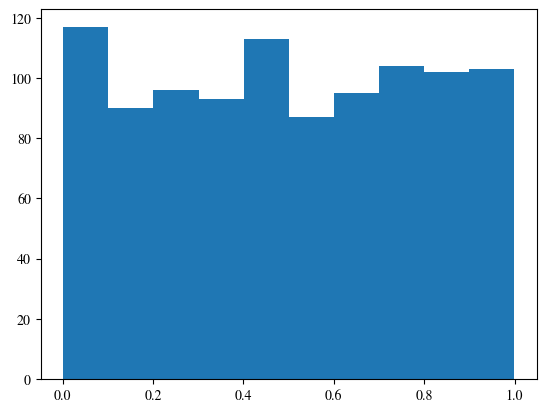

In [78]:
plt.hist(random_input.detach().cpu().numpy()[:,0])

(array([25., 17., 29., 24., 22., 22., 21., 13., 13., 21., 24., 16., 22.,
        26.,  8., 23., 16., 23., 16., 15., 18., 24., 24., 26., 21., 17.,
        17., 19., 17., 17., 26., 22., 14., 19., 14., 14., 22., 29., 16.,
        23., 22., 18., 20., 27., 15., 18., 16., 24., 21., 24.]),
 array([-0.4638622 , -0.4453545 , -0.42684677, -0.40833908, -0.38983136,
        -0.37132365, -0.35281593, -0.3343082 , -0.31580052, -0.2972928 ,
        -0.27878508, -0.26027736, -0.24176966, -0.22326194, -0.20475423,
        -0.18624651, -0.1677388 , -0.14923109, -0.13072337, -0.11221566,
        -0.09370795, -0.07520024, -0.05669252, -0.03818481, -0.0196771 ,
        -0.00116938,  0.01733833,  0.03584604,  0.05435375,  0.07286147,
         0.09136918,  0.10987689,  0.1283846 ,  0.14689232,  0.16540003,
         0.18390775,  0.20241547,  0.22092317,  0.23943089,  0.2579386 ,
         0.2764463 ,  0.29495403,  0.31346175,  0.33196944,  0.35047716,
         0.36898488,  0.3874926 ,  0.40600032,  0.424508  ,

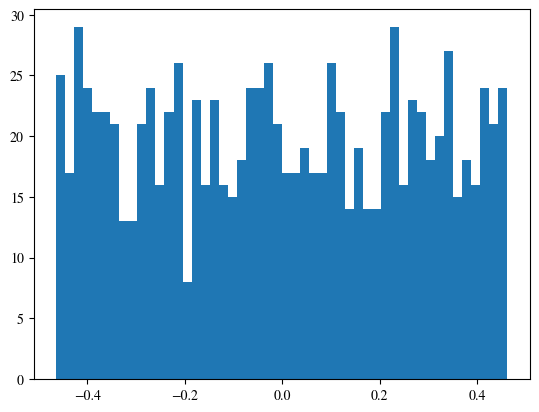

In [79]:
plt.hist(output.detach().cpu().numpy()[:,0], bins = 50)

In [51]:
softplus = nn.Softplus()

In [70]:
class RadialFlow(nn.Module):
    def __init__(self, input_dim):
        super(RadialFlow, self).__init__()
        self.input_dim = input_dim
        self.alpha = nn.Parameter(torch.randn(input_dim))
        self.beta = nn.Parameter(torch.randn(input_dim))
        self.gamma = nn.Parameter(torch.randn(input_dim))

    def forward(self, z):
        
        
        num = softplus(self.alpha) * (torch.exp(self.beta)-1) * (z - self.gamma) 
        den = softplus(self.alpha) + (z - self.gamma) 
        
        z_flow = z + num / den
        
        r = torch.abs(z-self.gamma)
        h = 1 / (softplus(self.alpha) + r)
        
        term1 = (1 + softplus(self.alpha) * (torch.exp(self.beta)-1) * h)**(self.input_dim -1)
        term2 = 1 + softplus(self.alpha) * (torch.exp(self.beta)-1) * h - softplus(self.alpha) * (torch.exp(self.beta)-1) * r *h**2
        
        det_jacobian = term1*term2
        
        return z_flow, det_jacobian

class NormalizingFlow(nn.Module):
    def __init__(self, input_dim, num_flows):
        super(NormalizingFlow, self).__init__()
        self.flows = nn.ModuleList([RadialFlow(input_dim) for _ in range(num_flows)])

    def forward(self, z):
        det_jacobian = torch.ones(z.size(0), 1).to(device)
        for flow in self.flows:
            z, jacobian = flow(z)
            det_jacobian *= jacobian
        return z, det_jacobian

In [71]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [1, 1.5, 2.0, 5.0]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)


    return torch.mean(XX + YY - 2. * XY)

In [98]:
RadialFlow(1)

RadialFlow()

In [81]:
# Define dimensions
input_dim = 1

z_dim = input_dim
nepochs=10000

bs=1000
num_flows=100
# Instantiate the PlanarFlow transformation
flow = NormalizingFlow(input_dim, num_flows).to(device)

base_distribution = D.Normal(torch.zeros(z_dim), torch.ones(z_dim))


In [82]:
random_input = torch.rand(10000, input_dim)
dset = TensorDataset(random_input)
loader = DataLoader(dset, batch_size=1000, shuffle=True)

In [95]:
optimizer = optim.Adam(flow.parameters(), lr=1e-3, weight_decay=1e-4)

for e in range(nepochs):
    for x in loader:
        #assert False
    
        optimizer.zero_grad()
        randomN_input = torch.randn(len(x[0]), input_dim).to(device)

        output, det_jacb = flow(x[0].to(device))
    
        loss =  MMD(output,randomN_input, kernel='rbf')-base_distribution.log_prob(output.cpu()).to(device) + torch.log(det_jacb) #
        loss = loss.mean()
        loss.backward()
        optimizer.step() 
    
    print('epoch:',e, loss.item())
    
    
    

epoch: 0 28200.544921875
epoch: 1 1129.369384765625
epoch: 2 21.443578720092773
epoch: 3 112.31295776367188
epoch: 4 149.22096252441406
epoch: 5 33502.9375
epoch: 6 110.99540710449219
epoch: 7 271.1609191894531
epoch: 8 57.25232696533203
epoch: 9 73.51012420654297
epoch: 10 97.47554779052734
epoch: 11 123.52039337158203
epoch: 12 221.76556396484375
epoch: 13 225.6431427001953
epoch: 14 36.62788772583008
epoch: 15 788.5504150390625
epoch: 16 905.950927734375
epoch: 17 359.9490661621094
epoch: 18 94.8775863647461
epoch: 19 1562.370849609375
epoch: 20 68.43376159667969
epoch: 21 120.20706939697266
epoch: 22 117.14567565917969
epoch: 23 156.90737915039062
epoch: 24 64.27742767333984
epoch: 25 72.80873107910156
epoch: 26 299.83074951171875
epoch: 27 198.3571014404297
epoch: 28 67.56690979003906
epoch: 29 59.80242156982422
epoch: 30 152.69972229003906
epoch: 31 85.3028335571289
epoch: 32 2329.72314453125
epoch: 33 50.84280776977539
epoch: 34 25396.7109375
epoch: 35 1737.4556884765625
epoch: 

KeyboardInterrupt: 

(array([  0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   3.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   4.,   2.,
          0.,   0.,   0., 112.,  59.,  70.,  72.,  74.,  71.,  99., 111.,
        127.,  71.,  10.,   9.,  11.,  17.,   6.,   6.,   4.,   5.,   1.,
          1.,   4.,   4.,   7.,   2.,   3.]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
          8. ,   8.4,   8.8,   9.2,   9.6,  10. ], dtype=float32),
 <BarContainer object of 50 artists>)

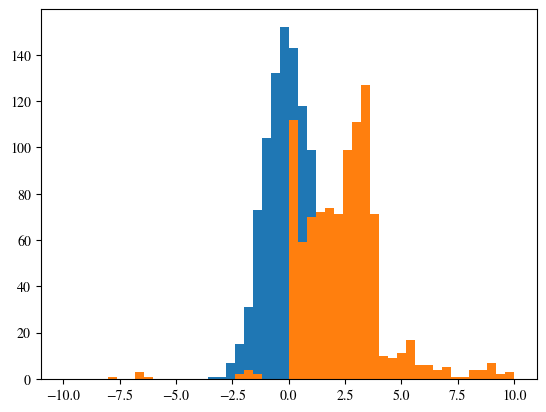

In [97]:
plt.hist(randomN_input.detach().cpu().numpy()[:,0], bins = 50, range=(-10,10))
plt.hist(output.detach().cpu().numpy()[:,0], bins = 50, range=(-10,10))


In [280]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)


    return torch.mean(XX + YY - 2. * XY)

In [281]:
    x = torch.rand(bs, input_dim)
    y = torch.randn(bs, input_dim)

In [283]:
MMD(x.cuda(), y.cuda(), kernel='rbf')

tensor(0.0637, device='cuda:0')

## WITH A VARIATIONAL AUTOENCODER

In [ ]:
import torch.nn as nn
import torch
class CondVAE(nn.Module):
    def __init__(self, dim_input, latent_dim=10, size=[150,150]):
        super(CondVAE, self).__init__()
        
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=dim_input, out_features=size[0]*size[1]),
            nn.Unflatten(1, (1, size[0], size[1], 60)),
            nn.ReLU(),
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(16384, latent_dim)
        self.fc_logvar = nn.Linear(16384, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 8, 16384), 
            nn.Unflatten(1, (256, 8, 8)),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=1, padding=0),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)

        return mu, log_var
    
    def decode(self, z, properties):
        # Concatenate the sampling (latent distribution) + embedding -> samples conditioned on both the input data and the specified label
        #print(properties.shape, z.shape)
        zcomb = torch.concat((z, properties), 1)
        #print(zcomb.shape)
        
        return self.decoder(zcomb)     
    
    def sampling(self, mu, log_var):
        # calculate standard deviation
        std = log_var.mul(0.5).exp_()
        
        # create noise tensor of same size as std to add to the latent vector
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        
        # multiply eps with std to scale the random noise according to the learned distribution + add combined
        return eps.mul(std).add_(mu) # return z sample 

    def forward(self, x, properties):
        mu, log_var = self.encode(x)
        z = self.sampling(mu, log_var)
        #print(z.shape)

        return self.decode(z, properties), mu, log_var
